In [16]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from IPython.display import display, Markdown, Latex
import sympy
from plot import *

# from sympy import *
# from sympy.physics.units import *

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 15, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
#plt.rcParams['font.family'] = "serif"
#plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r"\usepackage{subdepth}, \usepackage{type1cm}"

def display_var(var, value, unit=None, preface=None):
    display(Markdown("$\\text{{ {}${} = {:.3f} \\text{{ {} }} $ }} $".format(preface or "", var, value, unit or "")))


# Veloceration

_Introduction_

# Background

...

In a multidimensional system, the doppler frequency doesn't scale with the speed of the object, but rather what will be referred to as the _radial velocity_ of the object relative to the sensor's microphone, to be denoted as $\dot r$.

$$ \vec r_i = \vec q - \vec p_i $$
$$ \dot r_i = \vec v \cdot \hat r_i $$

Here, $\vec q$ denotes the position of the moving body, $\vec p_i$ denotes the i\textsuperscript{th} sensor's position, and $\hat r_i$ denotes the noramlized vector representing the direction of the object from the sensor. $v$ denotes the velocity of the object, so dotting it with $\hat r_i$ gives the projection of this velocity on the $r_i$ axis, thus giving the radial velocity of the object relative to sensor $i$.

The following python will be used throughout to perform this projection.

In [14]:
# Project v onto p-ps
def radial_velocity(ps, q, v):
    r = q - ps
    return np.dot(v, r/la.norm(r))

...

# Aproach
## Simulation

Simulating a system like this is actually rather straight forward. The goal of each simulation is to determine the performance of each set of parameters. The key parameters are the sample frequency, $f_s$, which affects the limits of all other parameters and performance characteristics. Primarily, it determines the highest frequency which can be detected by the system, in accordance with the Nyquist Sampling Theorm $f_s > 2f_{max}$. In our application, $f_{max}$ is going to be the emitted frequency doppler shifted by the maximum speed we want to detect. In general, the doppler shift will be very small compared to the frequency itself, so we'll generalize the constraint to be

$$ f_s > 2f_0 $$

where f_0 is the emitted frequency. $f_0$ itself affects the performance characteristics a marginal amount. The doppler effect is defined as

$$ f_\text{doppler} = {c \over c+v} f_0 $$

When a standard Discrete Fourier Transform is used to find frequencies, a higher $f_0$ will result in a proportional shift in $f_\text{doppler}$ as a result, which will span more frequency bins in the transform.

In [3]:
c = 343 # m/s

# Returns the frequency shifted by the doppler effect for a given velocity 'v'
def doppler(f0, v):
    return c / (c + v) * f0

display_var(
    "f_0 - f_\\text{doppler}"
    , 5000 - doppler(5000, 1)
    , "Hz"
    , " for $f_0 = 5000$ Hz: "
)

display_var(
    "f_0 - f_\\text{doppler}"
    , 22000 - doppler(22000, 1)
    , "Hz"
    , " for $f_0 = 22000$ Hz: "
)

$\text{  for $f_0 = 5000$ Hz: $f_0 - f_\text{doppler} = 14.535 \text{ Hz } $ } $

$\text{  for $f_0 = 22000$ Hz: $f_0 - f_\text{doppler} = 63.953 \text{ Hz } $ } $

The next important parameter is $n_s$, which is the number of samples used for each Fourier Transform. First and foremost, $n_s$ determines the amount of time over which samples are gathered for one calculation, $T_{FFT}$. 

$$ T_{FFT} = T_s n_s = {n_s \over f_s} $$

In [4]:
# Returns the sample period given a sample frequency
def sample_period(f_s):
    return 1 / f_s

# Returns the time (in seconds) over which one transform would be calculated
def fft_period(T_s, n):
    return T_s * n

display_var(
    "T_s"
    , sample_period(44100) * 1000
    , "ms"
)

display_var(
    "T_{FFT}"
    , fft_period(sample_period(44100), 8192) * 1000
    , "ms"
)

$\text{ $T_s = 0.023 \text{ ms } $ } $

$\text{ $T_{FFT} = 185.760 \text{ ms } $ } $

The number of samples also defines the number of frequency bins that will be in the resulting Transform $2n_\text{bins} = n_s$. The more frequency bins there are, the higher the resolution of the spectrum, $f_\text{bin}$ since those bins are distributed over the Nyquist frequency $f_s \over 2$.

In [5]:
# Returns the number of hertz per frequency bin in the fft
def freq_per_bin(T_s, n):
    return 1 / fft_period(T_s, n)

''' For a given set of parameters, returns the resolution with which
    the system will be able to detect the doppler effect.
    Essentially by resolution we mean the number of bins that span
    the range of velocities we want to detect.
'''
def resolution(T_s, n, f0, vmax):
    return abs(int((doppler(f0, vmax) - f0) / freq_per_bin(T_s, n)))

display_var(
    "f_\\text{bin}"
    , freq_per_bin(sample_period(44100), 8192)
    , "Hz"
)

display_var(
    "\\text{resolution}"
    , resolution(sample_period(44100), 8192, 22000, 1)
)

$\text{ $f_\text{bin} = 5.383 \text{ Hz } $ } $

$\text{ $\text{resolution} = 11.000 \text{  } $ } $

In general, $n_{s}$ will also be chosen as a power of 2 as FFT algorithms run most efficently for those sample counts.

With all of these parameters defined, we can simulate the signal that would be seen by a sensor rather simply.

The `signal_gen` function shown below generates the samples needed for the FFT. It takes in the sample-period $(T_s)$, the number of samples ($n$), and the emitted velocity ($f_0$).

Additionally, we need to simulate the actual kinematics of the sensor and object. This function takes in the position of the sensor ($p_\text{sensor}$), the starting point of the object ($p_\text{start}$), and the velocity of the object ($v$) in the same reference frame.

At each time-step, the function determines the position of the object relative to the sensor ($r$), and then finds the projection of the object's velocity along that vector ($w$). This is the speed needed to compute the frequency which will be sensed according to the doppler effect ($f$). Finally, each sample of the signal is modeled as the interference of two sinusoidal signals with the emitted frequency and shifted frequency.

The emitted frequency is added here to simulate the sensor's mic picking up $f_0$, which happens in the scheme where the sensor emits $f_0$ and the doppler shift occurs as it is reflected by the object's frequency. This term can be removed when simulating an object which is responsible for emitting $f_0$.

The `intensity_factor` being multiplied by the doppler frequency's sinusoidal is used to represent the attenuation of the pressure of a sound-wave picked up by a microphone. This pressure is taken inversely with distance. Its mutliplied by a constant here just to make it easy to see on the same scale as the $f_0$ spike. The pressure will remain unitless throughout the analysis as the algorithm really only applies to the relative signal strength the mic would pick up as a result of the varying sound intensity.

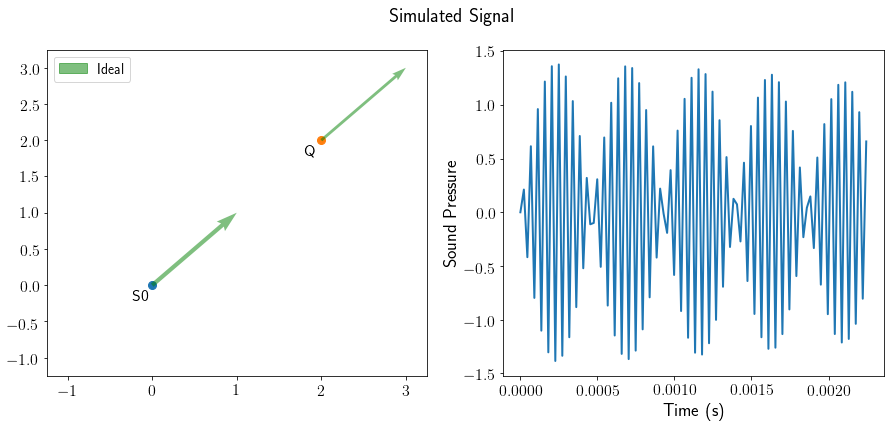

In [17]:
''' Generates the signal received by a sensor at 'sensor' and a target object
    at 'start' moving at a 'velocity' due to the doppler effect of the
    frequency 'f0'
'''
def signal_gen(T_s, n, p_sensor, p_start, v, f0):
    t = 0
    for i in range(n):
        r = p_start - p_sensor + v*t
        
        # Used to scale the shifted frequency inversely with distance
        intensity_factor = 1/la.norm(r)*1.1
        
        w = np.dot(v, r / la.norm(r))
        f = doppler(f0, w)
        yield intensity_factor*math.sin(2*math.pi*f*t) + math.sin(2*math.pi*f0*t)
        t += T_s
        
f0 = 21000
f_s = 44100
T_s = sample_period(f_s)
n = 8192
p0 = np.array([0, 0])
q = np.array([2, 2])
v = np.array([1, 1])
vr = radial_velocity(p0, q, v)

signal = list(
    signal_gen(
        T_s
        , n
        , p0
        , q
        , v
        , f0
    )
)



times = [i*T_s for i in range(len(signal))]

setup, far = side_by_side("Simulated Signal")

plot_layout(setup, [p0], q=q, v=v, vr=[vr])

simple_plot(far
            , signal[:100]
            , times[:100]
            , xlabel="Time (s)"
            , ylabel="Sound Pressure"
           )


The left plot shows the layout of the sensor and object. The green arrow on the object indicates its velocity vector, while the green arrow on the sensor indicates the projection of this velocity towards that sensor.
The right plot shows the first 100 samples of simulation. Since $f_0$ is so close to the Nyquist frequency, each sample almost fully inverts the last. The waxing and waning of the amplitude is due to bandwidth and $f_0$ being out of phase.

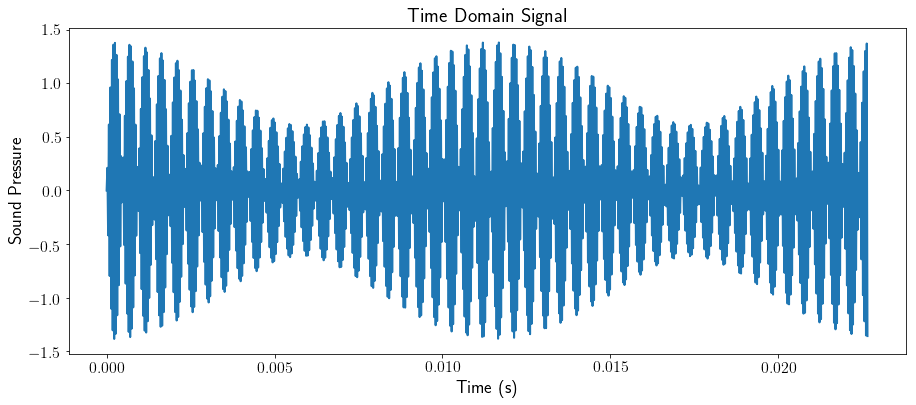

In [18]:
simple_plot(not_side_by_side()[0]
            , signal[:1000]
            , times[:1000]
            , xlabel="Time (s)"
            , ylabel="Sound Pressure"
            , title="Time Domain Signal")

This plot shows the first 1000 samples of the signal. There is a second degree of the amplitude's waxing and waning which indicates the doppler frequency being out of phase with both the Nyquist frequency and $f_0$.

It's precisely these predictable features which allow a Discrete Fourier Transform to extract the frequencies which result in them.

The `signal_gen` function is the extent of the "simulation" aspect of the code. The rest of the code treats these incoming signals the same way a physical microphone would, such that the code _could_ be deployed to a physical system.

## Algorithm

### Individual Sensor Frequency Extraction
To determine the dominant frequencies in the incoming signals, a numpy method which computes a Discrete Fourier Transform is used. `np.fft.rfft` is the real fft, which operates on real valued samples. Since real-valued frequency transforms just have duplicate bins for complex conjugates, this function only returns half of the frequency spectrum, so the number of bins is half of the number of samples.

$\text{ $n_\text{bins} = 4097.000 \text{  } $ } $

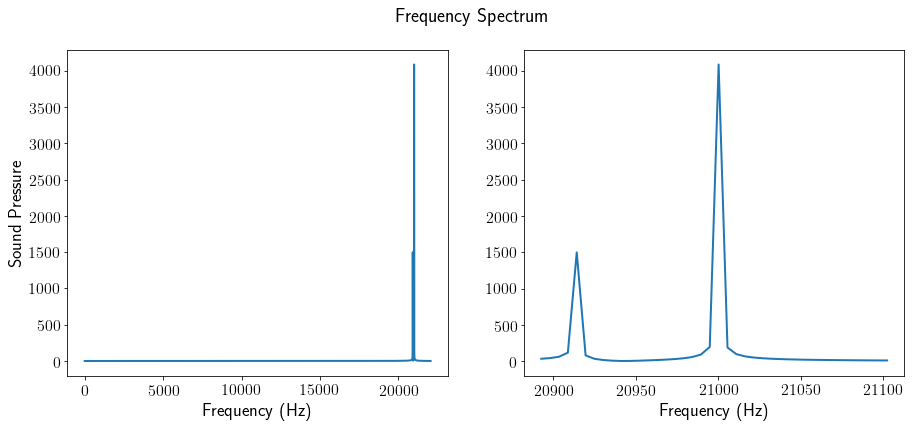

In [19]:
def freq_spectrum(signal):
    return [np.absolute(sample) for sample in np.fft.rfft(signal)]

# reusing signal calculated above
spectrum = freq_spectrum(signal)
n_bins = len(spectrum)
f0_bin = round(f0/freq_per_bin(T_s, n))
rng = 20
display_var("n_\\text{bins}", n_bins)

freqs = [freq_per_bin(T_s, n)*i for i in range(n_bins)]
left, right = side_by_side("Frequency Spectrum")

simple_plot(left
            , spectrum
            , freqs
            , "Frequency (Hz)"
            , "Sound Pressure"
           )
simple_plot(right
            , spectrum[f0_bin-rng:f0_bin+rng]
            , freqs[f0_bin-rng:f0_bin+rng]
            , "Frequency (Hz)"
           )

Here the frequency spectrum of the signal from earlier is shown. As expected, there are two spikes in the spectrum. One around $f_0$, and one offset from $f_0$ which is spread over a slightly larger region and is less uniform.

This offset is to the left of the $f_0$ spike. This is intuitive, as the object is moving away from the sensor, which results in the doppler effect shifting the frequency lower, like after an ambulance has passed you.

The next few functions are used to help find the peak in the spectrum representing the shifted frequency. 

In [9]:
# Finds a local min
def find_next_low(data):
    minv = None
    for i, v in enumerate(data):
        if minv is None:
            minv = v
        elif v < minv:
            minv = v
        else:
            return i-1
    return len(data)

# Finds the global max starting at the first local min
def find_next_peak(data):
    maxv = 0
    ret = 0
    start = find_next_low(data)
    data = data[start:]
    for i, v in enumerate(data):
        if v > maxv:
            maxv = v
            ret = i   
    return start + ret

# Returns mean and standard deviation of input data
def characterize_peak(data):
    sumweight = 0
    sumdata = 0
    for i, v in enumerate(data):
        sumweight += v
        sumdata += i*v

    mean = sumdata / sumweight

    variance = 0
    for i, v in enumerate(data):
        variance += v / sumweight * (mean - i)**2

    std_dev = math.sqrt(variance)

    return (mean, std_dev)

These are utilized in the `find_shift` function, which works by searching from the $f_0$ frequency in both directions looking for the highest peak in the data, excluding the $f_0$ peak. It then returns the offset $\Delta f$ of that frequency, the standard deviation of the confidence interval of the frequency $\sigma_f$, and the intensity of the peak $a$ relative to the intensity of $f_0$.

In [10]:
# Used to determine how far from f0 find_shift will search for a doppler shifted frequency
max_vel = 30

''' Finds the doppler shifted frequency in a spectrum about f0.
    Returns the mean and standard deviation.
    
    This function takes the input spectrum and searches for the shifted frequency
    by scanning left and right from the bin corresponding to f0 for the highest
    spike in the data. 
'''
def find_shift(T_s, f0, spectrum):
    n = (len(spectrum)-1)*2
    fpb = freq_per_bin(T_s, n)
    
    peak_range = doppler(f0, max_vel)
    
    f0_bin = round(f0 / fpb)
    bin_range = int(peak_range / fpb)
    
    
    # Find highest bin in search range to left and right of f0 peak
    left_peak = f0_bin - find_next_peak(spectrum[f0_bin:f0_bin-bin_range:-1])
    right_peak = f0_bin + find_next_peak(spectrum[f0_bin:f0_bin+bin_range])
    
    max_peak = max((left_peak, right_peak),
                key=lambda x: spectrum[x] if 0 <= x < len(spectrum) else 0)
    
    peak_start = find_next_low(spectrum[max_peak:max_peak-bin_range:-1])
    peak_end = find_next_low(spectrum[max_peak:max_peak+bin_range])
    
    # symmetry
    peak_start = peak_end = min(peak_start, peak_end)
    
    if peak_start == 0:
        return 0, 2*freq_per_bin(sample_period, samples), 0
    
    mean, std_dev = characterize_peak(spectrum[max_peak-peak_start:max_peak+peak_end])
    mean += max_peak-peak_start
    
    freq_mean = mean*fpb
    std_dev = std_dev*fpb
    
    return f0 - freq_mean, std_dev, spectrum[max_peak]/spectrum[f0_bin]

df, sigma, a = find_shift(T_s, f0, spectrum)
display_var("f_\\text{shift} = \Delta f"
            , df
            , "Hz"
            , "Frequency Shift: "
           )

display_var("\sigma_f"
            , sigma
            , "Hz"
            , "Standard Deviation: "
           )

display_var("a"
            , a
            , "of $f_0$"
            , "Sound Pressure Intensity: "
           )



$\text{ Frequency Shift: $f_\text{shift} = \Delta f = 87.071 \text{ Hz } $ } $

$\text{ Standard Deviation: $\sigma_f = 6.183 \text{ Hz } $ } $

$\text{ Sound Pressure Intensity: $a = 0.367 \text{ of $f_0$ } $ } $

With the frequency shift we can extract the velocity that generated it, by using the doppler effect equation. This can also be applied to our standard deviation value to get the standard deviation of this velocity value.

In [11]:
c = 343 # m/s

# Returns the velocity based on the known frequency shift
def inv_doppler(f0, df):
    return df/f0*c

v_doppler = inv_doppler(f0, df)
sigma_doppler = inv_doppler(f0, sigma)
display_var("\dot r_\\text{doppler}"
            , v_doppler
            , "m/s"
            , "Doppler Velocity: "
)

display_var("\sigma_{\dot r_\\text{doppler}}"
            , sigma_doppler
            , "m/s"
            , "Doppler Velocity: "
           )

$\text{ Doppler Velocity: $\dot r_\text{doppler} = 1.422 \text{ m/s } $ } $

$\text{ Doppler Velocity: $\sigma_{\dot r_\text{doppler}} = 0.101 \text{ m/s } $ } $

Recalling from the beginning of this example simulation, the original velocity was $[1, 1]^T$, which has magnitude $\sqrt{2} \approx 1.41$, which is very to our calculated velocity, and certainly within the $1\sigma_{\dot r_\text{doppler}}$ confidence interval. Note that we only expect the radial velocity to match the magnitude of the true velocity when the object is either moving directly away from the object (and minus the magnitude when moving directly towards it).

The following example simulation will show a case where the sensor and object have the same $y$-value, such that we expect the radial velocity to be the x-component of the object's velocity vector.

$\text{ True Radial Velocity: $\dot r = 1.000 \text{ m/s } $ } $

$\text{ Estimated Radial Velocity: $\dot r_\text{doppler} = 1.083 \text{ m/s } $ } $

$\text{ Measurement Standard Deviation: $\sigma_{\dot r_\text{doppler}} = 0.234 \text{ m/s } $ } $

$\text{ Error: $e_{\dot r} = 0.083 \text{ m/s } $ } $

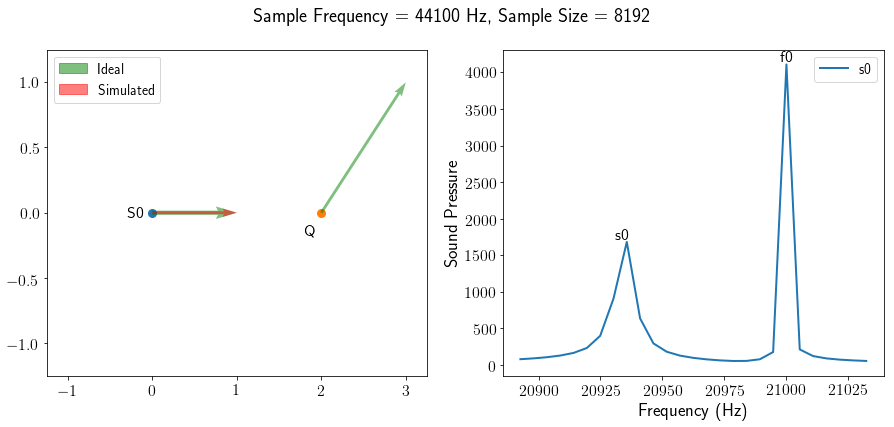

In [20]:
def simulate_single(f_s=f_s, n=n, f0=f0, p0=p0, q=q, v=v, batch=False):
    vr = radial_velocity(p0, q, v)
    T_s = sample_period(f_s)
    signal = list(signal_gen(T_s, n, p0, q, v, f0))
    spec = freq_spectrum(signal)
    df_mean, df_dev, a = find_shift(T_s, f0, spec)
    vd = inv_doppler(f0, df_mean)
    vd_dev = inv_doppler(f0, df_dev)
    err = abs(vd - vr)
    
    if batch:
        return err, vd_dev
    else: # Display key results and show plots
        display_var("\dot r"
                    , vr
                    , "m/s"
                    , "True Radial Velocity: "
        )

        display_var("\dot r_\\text{doppler}"
                    , vd
                    , "m/s"
                    , "Estimated Radial Velocity: "
        )

        display_var("\sigma_{\dot r_\\text{doppler}}"
                    , vd_dev
                    , "m/s"
                    , "Measurement Standard Deviation: "
        )
        
        display_var("e_{\dot r}", err, "m/s", "Error: ")

        left, right = side_by_side("Sample Frequency = {} Hz, Sample Size = {}".format(f_s, n))
        plot_layout(left, [p0], q=q, v=v, vr=[vr], vd=[vd], title="Layout")
        plot_spectrum(right, [spec], [df_mean], f0, freq_per_bin(T_s, n))
    

# Parallel on x-axis
simulate_single(
    p0=np.array([0, 0])
    , q=np.array([2, 0])
    , v=np.array([1, 1])
)

Once again that the true estimated radial velocity is within the confidence interval around the value estimated from the measurements.

#### Single Sensor Performance

##### Effect of Sample Frequency
The sample frequency controls the bandwidth, so it's a hard upper-bound on $2f_0$. What is the effect beyond $2f_0$ on the error, however?

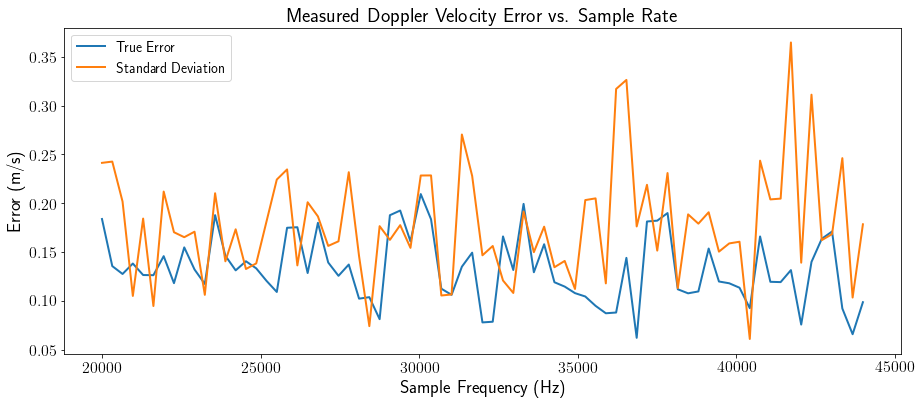

In [21]:
initial = 20000 # Hz
final = 44000 # Hz
sample_freqs = np.linspace(initial, final, 75).tolist()

# f0 is chosen here to be quite a bit lower than the nyquist frequency by an arbitrary amount
data = [simulate_single(f_s=float(f_s), f0=initial/2-999, q=np.array([2, 0]), batch=True)
        for f_s in sample_freqs]

ax, _ = not_side_by_side()
simple_plot(
    ax
    , [d[0] for d in data]
    , sample_freqs
    , "Sample Frequency (Hz)"
    , "Error (m/s)"
    , "Measured Doppler Velocity Error vs. Sample Rate"
)

simple_plot(ax, [d[1] for d in data], sample_freqs)

_ = ax.legend(["True Error", "Standard Deviation"])

It would seem there is no correlation between sample frequency and error. At most frequencies the error is under a single standard deviation, and it never spikes above by more than 2 standard deviations.

The largest the error gets is 0.25 m/s, which compared to the expected 1 m/s isn't fantastic. The smallest error is around 0.15 m/s, which is certainly better, but still not great.

The fact that there is always some error value greater than 0.15 indicates that there is a bias in the measurement technique, that is preferring a doppler velocity some amount greater than the true radial velocity.

##### Effect of $f_0$

$f_0$ is the base frequency emitted by the object which is shifted by the doppler effect. This shift is multiplicative 

### Estimation

With each sensor giving the velocity of the object along its radial axis, we want to derive the velocity of the object in the world space.

Given an object at unknown position $\vec q$ moving at unknown velocity $\vec v = \dot q$ and given the positions of $m$ sensors $\{\vec p_0 \ldots \vec p_{m-1}\}$, and the radial velocities of the object towards each sensor $\{\dot r_0, \ldots \dot r_{m-1} \}$, we want to find the velocity $\vec v$ of the object.

For starters, we have the distance equation of each sensor $i$ to the object:

$$ \lVert q - p_i \rVert^2  = r_i^2 $$

Then, we take the derivative of this equation with respect to time.

$$
\begin{align*}
    \lVert \vec q - \vec p_i \rVert^2 &=  r_i^2 \\
    (\vec q - \vec p_i) \cdot (\vec q - \vec p_i) &= r_i^2 \\
    2 (\vec q - \vec p_i) \cdot \dot q &= 2 r_i \dot r_i \\
    (\vec q - \vec p_i) \cdot \dot q &= r_i \dot r_i \\
    \vec q \cdot \dot q - \vec p_i \cdot \dot q &= r_i \dot r_i \\
    \vec q \cdot \dot q &= r_i \dot r_i + \vec p_i \cdot \dot q \\
\end{align*}
$$

In this final form, the left side of the equation is independent of the sensors, and so given a pair of sensors $i$ and $j$, we can set the right sides of their equations equal to each other:

$$
\begin{align*}
    r_i \dot r_i + \vec p_i \cdot \dot q &= r_j \dot r_j + \vec p_j \cdot \dot q \\
    \vec p_i \cdot \dot q - \vec p_j \cdot \dot q + r_i \dot r_i - r_j \dot r_j &= 0 \\
    (\vec p_i - \vec p_j) \cdot \dot q + \dot r_i r_i - \dot r_j r_j &= 0 \\
\end{align*}
$$

